# Aplicando o método de vizinhos mais próximos (knn).

Para esse exemplo, será utilizada uma base de dados onde cada observação corresponde a idade de determinado bebê (em semanas) e seu comprimento (em centímetros).
Antes de começar a análise, serão importadas as bibliotecas utilizadas nesse exemplo.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

In [23]:
np.random.seed(42)

In [57]:
# To plot pretty figures directly within Jupyter
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

A base utilizada aqui está no formato '.RData', que é mais utilizado no R. Para trabalhar com essa base em Python, será utilizada a biblioteca 'pyreadr'.

In [2]:
!pip install pyreadr

     |████████████████████████████████| 409 kB 7.6 MB/s 


In [3]:
import pyreadr

In [4]:
dataR = pyreadr.read_r('bebes.RData')

In [42]:
print(dataR.keys())

odict_keys(['bebes'])


In [5]:
data = dataR['bebes']

Abaixo, vamos verificar a base que temos em mãos.

In [140]:
data.head()

,comprimento,idade
0,63.07,19.00
1,65.63,21.00
2,65.63,22.50
3,66.73,22.50
4,66.37,23.25


In [139]:
data.describe()

,comprimento,idade
count,74.000000,74.000000
mean,66.921622,25.312162
std,12.852386,12.975168
min,31.900000,2.150000
25%,56.470000,12.500000
50%,70.400000,26.000000
75%,75.807500,33.000000
max,87.630000,60.000000


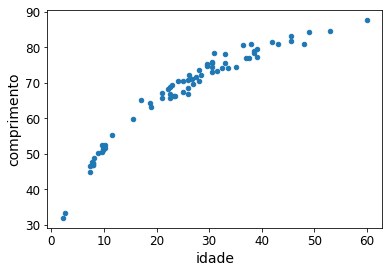

In [58]:
data.plot(kind='scatter', x="idade", y='comprimento')
plt.show()

Pelo gráfico acima, podemos perceber que os dados tem um formato que lembra uma função logarítmica.
Apesar desse formato específico deixar claro que os dados não se comportam de forma linear, iremos estimar um modelo de regressão linear nesse primeiro passo. Essa estimação servirá apenas para demonstrar a diferença de desempenho entre a regressão linear e um método não linear (nesse caso, o knn) quando os dados não são lineares.

In [60]:
X = np.c_[data['idade']]
y = np.c_[data['comprimento']]

Aqui estamos estimando uma regressão linear, utilizando a variável 'comprimento' como dependente e a variável 'idade' como explicativa.

In [148]:
# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

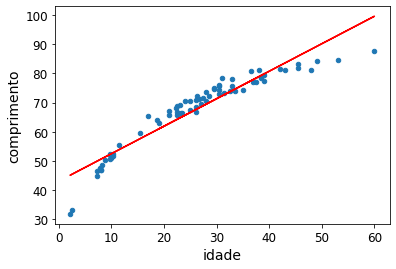

In [64]:
data.plot(kind = 'scatter',x="idade", y='comprimento')
plt.plot(np.sort(X),model.predict(X=np.sort(np.c_[data['idade']])), color = 'red')
plt.show()

O gráfico acima mostra a distribuição dos dados e o modelo estimado no passo anterior, representado pela reta vermelha.
É possível perceber que o modelo não está bem ajustado aos dados. Isso acontece, claro, porque os dados não se comportam de forma linear.

Portanto, vamos estimar um modelo utilizando o método knn. Como o knn utiliza noções de distância entre observações para atribuir valores em suas predições, primeiro transformaremos nossos dados.

Isso acontece porque a variável 'idade' tem uma escala diferente da variável 'comprimento', a idade dos bebês varia de 2,15 a 60 semanas, enquanto que o comprimento varia de 31,9cm a 87,63cm.

Então, vamos padronizar nossos dados para que eles fiquem no mesmo intervalo, nesse caso, entre 0 e 1.

In [38]:
dataS = (data - np.min(data))/(np.max(data)-np.min(data))

In [67]:
np.min(dataS)

comprimento    0.0
idade          0.0
dtype: float64

In [66]:
np.max(dataS)

comprimento    1.0
idade          1.0
dtype: float64

In [43]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Uma vez que transformamos nossos dados, vamos separá-los em dois grupos, o de treino e o de teste. Esse procedimento nos ajudará a avaliar nosso modelo.

In [216]:
train_set, test_set = split_train_test(dataS, 0.2)
len(train_set)

60

In [69]:
import sklearn.neighbors
modelK = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

Para começar nosso modelo, vamos utilizar o knn com 3 vizinhos. 

In [70]:
modelK.fit(np.c_[train_set['idade']],np.c_[train_set['comprimento']])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [73]:
pred = modelK.predict([[(59- np.min(data['idade']))/(np.max(data['idade'])-np.min(data['idade']))]])

In [74]:
pred

array([[0.96273701]])

In [75]:
pred*(np.max(data['comprimento'])-np.min(data['comprimento']))+np.min(data['comprimento'])

array([[85.55333333]])

In [77]:
X = np.c_[dataS['idade']]
y = np.c_[dataS['comprimento']]

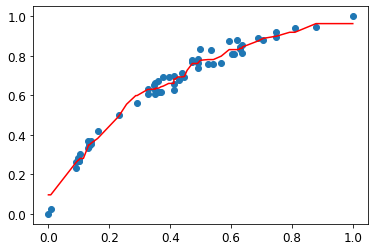

In [78]:
plt.scatter(x="idade", y='comprimento', data = train_set)
plt.plot(np.sort(X, axis = 0),np.sort(modelK.predict(X), axis=0), color = 'red')
plt.show()

O gráfico mostra que esse modelo se ajusta aos dados de forma muito mais eficiente que a regressão linear. Mas ainda não sabemos se o modelo ideal realmente leva em consideração 3 vizinhos.

Portanto, vamos verificar qual é o melhor modelo. Para isso, vamos utilizar a raiz do erro quadrático médio (RMSE) como métrica de perfomance.

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [79]:
rmse_val = [] 
for K in range(20):
    K = K+1
    model = sklearn.neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(np.c_[train_set['idade']], np.c_[train_set['comprimento']])  #fit the model
    pred=model.predict(np.c_[test_set['idade']]) #make prediction on test set
    error = sqrt(mean_squared_error(np.c_[test_set['comprimento']],pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.05153383100382558
RMSE value for k=  2 is: 0.0382718309198484
RMSE value for k=  3 is: 0.03525557320373754
RMSE value for k=  4 is: 0.02761747912775354
RMSE value for k=  5 is: 0.024455080047393
RMSE value for k=  6 is: 0.026201082106420623
RMSE value for k=  7 is: 0.025210857982082793
RMSE value for k=  8 is: 0.025892089720650838
RMSE value for k=  9 is: 0.026306819252158165
RMSE value for k=  10 is: 0.026021938297343405
RMSE value for k=  11 is: 0.023808577573111753
RMSE value for k=  12 is: 0.024933688241360545
RMSE value for k=  13 is: 0.026772521624602745
RMSE value for k=  14 is: 0.03107029766047451
RMSE value for k=  15 is: 0.02997815129656553
RMSE value for k=  16 is: 0.034458916233689116
RMSE value for k=  17 is: 0.036694849039916856
RMSE value for k=  18 is: 0.03456989371431495
RMSE value for k=  19 is: 0.035041419799093754
RMSE value for k=  20 is: 0.033765787119205394


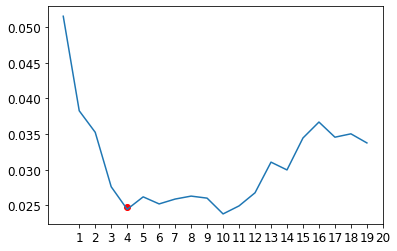

In [106]:
curve = pd.DataFrame(rmse_val) #elbow curve)
plt.plot(curve)
plt.xticks(np.arange(1, 21, 1.0))
plt.scatter(x=4, y=0.0248, color = 'red')
plt.show()

Podemos ver no gráfico que o RMSE cai até o modelo com 4 vizinhos e depois começa a subir. Portanto, vamos utilizar esse modelo como o que melhor se adapta aos nossos dados.

In [219]:
modelKnn = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 4)

modelKnn.fit(np.c_[train_set['idade']], np.c_[train_set['comprimento']])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

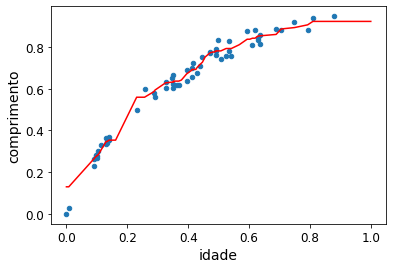

In [220]:
train_set.plot(kind='scatter',x="idade", y='comprimento')
plt.plot(np.sort(X, axis = 0),np.sort(modelKnn.predict(X), axis=0), color = 'red')
plt.show()

Como nossos dados foram transformados, para fazermos uma predição, temos que transformar, também, o valor que estamos interessados.

In [229]:
pred = modelKnn.predict([[(30.5- np.min(data['idade']))/(np.max(data['idade'])-np.min(data['idade']))]])
pred

array([[0.79279562]])

O comando acima transforma 30,5 para a mesma escala dos dados utilizados na estimação do modelo. Podemos perceber que o resultado obtido não faz sentido, o que é normal, já que teremos que transformá-lo de volta para a escala original dos dados. Isso será feito no comando abaixo.

In [228]:
pred*(np.max(data['comprimento'])-np.min(data['comprimento']))+np.min(data['comprimento'])

array([[76.0825]])

Portanto, nosso modelo nos diz que uma criança com 30,5 semanas de vida deverá ter, aproximadamente, 76cm.